## NLP - NATURAL LANGUAGE PROCESSING - 2024

### PROJETO DE ANÁLISE DE FAKE NEWS COM A UTILIZAÇÃO DO CORPUS FAKEBR A BIBLIOTECA NLTK EM PYTHON

#### 1 - INSTALAÇÃO DOS PACOTES NECESSÁRIOS

In [1]:
# AMBIENTE DE EXECUÇÃO DESTE PROJETO
# WINDOWS 11 PRO
# IDE VSCODE
# PYTHON 3.11.4

In [2]:
'''!python --version
!pip install update

!pip install pandas
!pip install numpy
!pip install scikit-learn
!pip install wordcloud
!pip install nltk
!pip install requests

!pip list'''

'!python --version\n!pip install update\n\n!pip install pandas\n!pip install numpy\n!pip install scikit-learn\n!pip install wordcloud\n!pip install nltk\n!pip install requests\n\n!pip list'

#### 2 - ESTRUTURA DE PASTA DO PROJETO

In [3]:
# Projeto_NLP_Fakenews/  "Pasta principal do projeto"
# Projeto_NLP_Fakenews/corpus/  "Pasta onde é baixado o corpus em zip e descompactado"
# Projeto_NLP_Fakenews/dataset/  "Pasta onde é salvo os arquivos csv em cada passo do tratamento"
# Projeto_NLP_Fakenews/imagem/  "Pasta onde é salvo as fotos utilizadas como máscara para nuvem de palavras"

#### 3 - IMPORTAÇÃO DOS PACOTES NECESSÁRIOS, CARREGAMENTO DAS FUNÇÕES CRIADAS E VARIÁVEIS GLOBAIS

In [ ]:
import os
import re
import unicodedata
import zipfile
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import nltk
import numpy as np
import pandas as pd
import requests
from nltk.collocations import (BigramAssocMeasures, BigramCollocationFinder, TrigramAssocMeasures, TrigramCollocationFinder)
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from PIL import Image
from sklearn import metrics
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from tqdm import tqdm
from wordcloud import WordCloud

def baixar_repositorio(url, caminho_destino):
    """_Função para baixar repositório em arquivo zip_"""
    if not os.path.exists(caminho_destino):
        os.makedirs(caminho_destino)
    print(f"### O DOWNLOAD do repositório {url} está sendo baixado ###") 
    resposta = requests.get(url, stream=True)
    tamanho_total = int(resposta.headers.get("content-length", 0))
    barra_progresso = tqdm(total=tamanho_total, unit="iB", unit_scale=True)
    caminho_arquivo = os.path.join(caminho_destino, "repositorio.zip")    
    with open(caminho_arquivo, "wb") as f: # Cria barra de progresso
        for data in resposta.iter_content(chunk_size=1024):
            tamanho = f.write(data)
            barra_progresso.update(tamanho)
    barra_progresso.close()
    if tamanho_total != 0 and barra_progresso.n != tamanho_total:
        print(f"### Erro no DOWNLOAD do repositório {url} , algo deu errado durante o download ###" + "\n")
    else:
        print(f"### O DOWNLOAD do repositório {url}, baixado com sucesso em {caminho_arquivo} ###" + "\n")

def descompactar_arquivo(caminho_arquivo, caminho_destino, nome_zip):
    """_Função para descompactar arquivo zip e verificar integridade_"""
    print(f"### O REPOSITÓRIO está sendo descompactado com sucesso em {caminho_destino} ###")
    caminho_arquivo = os.path.join(caminho_arquivo, nome_zip)
    with zipfile.ZipFile(caminho_arquivo, "r") as zip_ref:        
        if zipfile.is_zipfile(caminho_arquivo): # Verififica integridade do arquivo
            tamanho_total = sum([zinfo.file_size for zinfo in zip_ref.filelist])
            barra_progresso = tqdm(total=tamanho_total, unit="iB", unit_scale=True)            
            for zinfo in zip_ref.infolist(): # Cria barra de progresso
                zip_ref.extract(zinfo, caminho_destino)
                barra_progresso.update(zinfo.file_size)
            barra_progresso.close()
            print(f"### O REPOSITÓRIO foi descompactado com sucesso em {caminho_destino} ###" + "\n")
        else:
            print(f"### Erro no REPOSITÓRIO, o arquivo zip está corrompido." + "\n")

def ler_arquivos(caminho_arquivo, caminho_pasta, caminho_saida, nomes_colunas, condicao):
    """_Função para leitura dos arquivos csv originais e adequação das colunas e criar dataset_"""
    texts = []  # Crie uma lista para armazenar o texto de cada arquivo
    if condicao == "linha":        
        for arquivo in tqdm(os.listdir(caminho_arquivo + caminho_pasta), desc=f"Lendo arquivos {caminho_pasta}",): # Para cada arquivo na pasta
            if arquivo.endswith(".txt"):
                with open(os.path.join(caminho_arquivo + caminho_pasta, arquivo),"r", encoding="utf-8",) as f:                    
                    linhas = [linha.strip() for linha in f if linha.strip()] # Lê o arquivo e remove as linhas vazias                    
                    texts.append(" ".join(linhas)) # Adiciona as linhas do arquivo na lista de dados        
        df = pd.DataFrame(texts) # Converta a lista em um DataFrame
    elif condicao == "coluna":
        # Para cada arquivo na pasta
        for arquivo in tqdm(os.listdir(caminho_arquivo + caminho_pasta), desc=f"Lendo arquivos {caminho_pasta}",):
            if arquivo.endswith(".txt"):
                with open(os.path.join(caminho_arquivo + caminho_pasta, arquivo),"r",encoding="utf-8",) as f:                    
                    linhas = [linha.strip() for linha in f if linha.strip()] # Lê o arquivo e remove as linhas vazias                    
                    texts.append(";".join(linhas)) # Adiciona as linhas do arquivo na lista de dados        
        df = pd.DataFrame(texts) # Converta a lista em um DataFrame
        if np.size(nomes_colunas) == 25:            
            df[nomes_colunas] = df[0].str.split(";", expand=True) # Dividir coluna            
            df = df.drop(df.columns[[0, 0]], axis=1) # Remover coluna original
        elif np.size(nomes_colunas) == 26:            
            df = df.replace(to_replace=[r" , ", r", "], value="", regex=True) # Substituir "," por "." para evitar equívocos com números de colunas            
            df[nomes_colunas] = df[0].str.split(";", expand=True) # Dividir coluna            
            df = df.drop(columns=[0]) # Remover coluna original            
            df = df.drop(df.columns[[25, 25]], axis=1) # Remover coluna do final
    else:
        print(f"### Condição de orientação informada errada ###" + "\n")
    tqdm.pandas(desc=f"### Salvando DataFrame {caminho_pasta} como CSV ###") # Crie uma barra de progresso
    df.to_csv(os.path.join(caminho_saida, caminho_pasta + ".csv"),index=None, 
        encoding="utf-8", sep=";", na_rep="0")

def processar_dataset(caminho_saida, nome_arquivo, stopwords, nomes_colunas, condicao, tamanho_truncagem):
    """_Função para realizar o pré-processamento dos arquivos csv (remoção stopwords, lematização, truncagem da coluna, 
    conversão maiúsculas, remover acentuação, caracteres de pontuação, caracteres especiais, realizada a tokenização 
    e separação de palavras de bigramas e trigramas)_"""
    df = pd.read_csv(os.path.join(caminho_saida, nome_arquivo + ".csv"),
        index_col=False, sep=";", encoding="Utf-8")
    if condicao == "linha":
        df.rename(columns={"0": nomes_colunas}, inplace=True)
    elif condicao == "coluna":
        df.columns = nomes_colunas
    else:
        print("Condição de orientação informada errada")    
    df["news_text_normalized"] = df[nomes_colunas].str.lower() # Converta o texto para minúsculas antes de remover as stopwords     
    df["stopwords_removidas"] = df["news_text_normalized"].apply(
        lambda x: " ".join([word for word in x.split() if word in (stopwords)])) # Remova as stopwords
    df["news_text_normalized"] = df["news_text_normalized"].apply(
        lambda x: " ".join([word for word in x.split() if word not in (stopwords)])) # Remova as stopwords    
    df["quantidade_stopwords_removidas"] = df["stopwords_removidas"].apply(
        lambda x: len(x.split())) # Calcule a quantidade de stopwords removidas    
    quantidade_total = df["quantidade_stopwords_removidas"].sum() # Calcule a quantidade total de stopwords removidas
    print(f"### A quantidade total de STOPWORDS EM {nome_arquivo} é: {quantidade_total} ###")
    lemmatizer = WordNetLemmatizer() # Reduz as palavras em cada notícia para sua forma canônica (lemmatization)
    df["news_text_normalized"] = df["news_text_normalized"].apply(
        lambda x: " ".join([lemmatizer.lemmatize(word) for word in x.split()]))
    df[nomes_colunas] = df[nomes_colunas].str.upper() # Converta o texto para maiúsculas
    df["news_text_normalized"] = df["news_text_normalized"].str.upper()
    df["news_text_normalized"] = df["news_text_normalized"].apply(
        lambda x: "".join((c for c in unicodedata.normalize("NFD", x)
                if unicodedata.category(c) != "Mn"))) # Remova a acentuação    
    df["news_text_normalized"] = df["news_text_normalized"].apply(
        lambda x: re.sub(r"[^\w\s]", "", x)) # Remova os caracteres de pontuação
    df["news_text_normalized"] = df["news_text_normalized"].apply(
        lambda x: x[:tamanho_truncagem] if len(x) > tamanho_truncagem else x) # Truncar o texto da coluna "news_text_normalized" para um tamanho determinado
    if nome_arquivo == "fake":
        df.insert(0, "id", ("2-" + "FAKE")) # Adicione uma nova coluna com o nome do arquivo        
        df.insert(1, "tag", "FAKE") # Adicione uma nova coluna com identificador
    elif nome_arquivo == "true":        
        df.insert(0, "id", ("1-" + "REAL")) # Adicione uma nova coluna com o nome do arquivo        
        df.insert(1, "tag", "REAL") # Adicione uma nova coluna com identificador
    else:
        print("### Nome do arquivo errado ###")
    df["tamanho_news_text_full"] = df["news_text_full"].apply(len) # Adicione uma nova coluna com o tamanho da coluna "news_text_full"
    menor_tamanho = df["tamanho_news_text_full"].min() # Calcule o menor tamanho da coluna "news_text_full"
    media_tamanho = df["tamanho_news_text_full"].mean() # Calcule o médio tamanho da coluna "news_text_full"
    maximo_tamanho = df["tamanho_news_text_full"].max() # Calcule o máximo tamanho da coluna "news_text_full"
    print(f"### Em {nome_arquivo} os tamanhos são ver abaixo ###")
    print(f"O menor é : {menor_tamanho} o médio é: {media_tamanho} maior é: {maximo_tamanho}" + "\n")
    df["tokens"] = df["news_text_normalized"].apply(nltk.word_tokenize) # Primeiro, vamos tokenizar a coluna do DataFrame
    bigram_measures = BigramAssocMeasures() # Agora, vamos encontrar os bigramas
    trigram_measures = TrigramAssocMeasures() # Agora, vamos encontrar os trigramas
    todos_tokens = [token for sublist in df["tokens"].tolist() for token in sublist] # Concatenar todos os tokens juntos em uma lista grande pode ajudar a encontrar colocações que ocorrem em diferentes linhas
    finder = BigramCollocationFinder.from_words(todos_tokens) # Encontrar e pontuar bigramas
    bigramas = finder.score_ngrams(bigram_measures.raw_freq)
    finder = TrigramCollocationFinder.from_words(todos_tokens) # Encontrar e pontuar trigramas
    trigramas = finder.score_ngrams(trigram_measures.raw_freq)
    contagem_palavras = len(todos_tokens) # Contar as palavras
    contagem_bigramas = len(bigramas) # Contar bigramas
    contagem_trigramas = len(trigramas) # Contar trigramas
    print(f"EM {nome_arquivo} as quantidades de palavras, bigramas e trigramas são ver abaixo ###")
    print(f"A de Palavras: {contagem_palavras}, de Bigramas: {contagem_bigramas}, de Trigramas: {contagem_trigramas}" + "\n")
    df.to_csv(os.path.join(caminho_saida, nome_arquivo + "_2.csv"), # Salvar em csv
        index=None, encoding="utf-8", sep=";", na_rep="0",)
    return

def combinar_csv(caminho_arquivo, arquiv1, arquiv2, arquiv3, arquiv4):
    """_Função para combinar arquivos csv_"""
    df_1 = pd.read_csv(os.path.join(caminho_arquivo, arquiv1 + "_2.csv"), # Leitura arquivos fake
        index_col=False,sep=";", encoding="Utf-8",)
    df_1 = df_1.drop(df_1.columns[[4, 5]], axis=1) # Remover colunas
    df_2 = pd.read_csv(os.path.join(caminho_arquivo, arquiv2 + ".csv"), # Leitura arquivos fake meta
        index_col=False, sep=";", encoding="Utf-8",)
    df_fake = pd.concat([df_1, df_2], axis=1) # Concatenar dataframes fake
    df_fake.to_csv(os.path.join(caminho_arquivo, arquiv1 + "_3.csv"), # Salvar em csv fake completo
        index=None, encoding="utf-8", sep=";", na_rep="0",)
    df_3 = pd.read_csv(os.path.join(caminho_arquivo, arquiv3 + "_2.csv"), # Leitura arquivos true
        index_col=False, sep=";", encoding="Utf-8",)
    df_3 = df_3.drop(df_3.columns[[4, 5]], axis=1) # Remover colunas
    df_4 = pd.read_csv(os.path.join(caminho_arquivo, arquiv4 + ".csv"), # Leitura arquivos true meta
        index_col=False, sep=";", encoding="Utf-8",)
    df_true = pd.concat([df_3, df_4], axis=1) # Concatenar dataframes true
    df_true.to_csv( os.path.join(caminho_arquivo, arquiv3 + "_3.csv"), # Salvar em csv true completo
        index=None, encoding="utf-8", sep=";",)
    df_final = pd.concat([df_fake, df_true]) # Concatenar dataframes fake completo e true completo
    df_final.to_csv(os.path.join(caminho_arquivo, "dataset_final_fake_true" + ".csv"), # Salvar em csv final
        index=None, encoding="utf-8", sep=";", na_rep="0",)

def dividir_treinamento(caminho_arquivo, nome_arquiv_final):
    """_Função para ler csv final com processamento e normalização e divisão em dataframes de traino e teste 70% e teste 30%_"""
    df = pd.read_csv(os.path.join(caminho_arquivo, nome_arquiv_final + ".csv"), # Leitura arquivos final
        index_col=False, sep=";", encoding="Utf-8",)
    X_train, X_test, y_train, y_test = train_test_split(df["news_text_normalized"], df["tag"], 
                                                        test_size=0.3, random_state=42, shuffle=True)  # Embaralha e separa treinamento e teste
    return X_train, X_test, y_train, y_test, df

def vetorizar_texto(X_train, X_test):
    """_Função para vetorizar os dados de texto usando o TF-IDF_"""
    vectorizer = TfidfVectorizer(ngram_range=(1, 2))
    train_vectors = vectorizer.fit_transform(X_train)
    test_vectors = vectorizer.transform(X_test)    
    return train_vectors, test_vectors

def modelagem_texto(train_vectors, y_train, test_vectors, y_test):
    """_Função para testar dados ao modelo de classificação Naive Bayes Multinomial e o treina com os dados de treinamento_"""
    lf = MultinomialNB().fit(train_vectors, y_train)
    predicted = lf.predict(test_vectors)
    return predicted

def verifica_accuracy(y_test, predicted, ru3891233):
    """_Função para calcular e exibir metricas obtidas pelo resultado modelo_"""
    relatorio = classification_report(y_test, predicted, target_names=["Fake", "Real"]) # calcula as métricas de classificação
    print(f"### Relatório de ACURÁRIA mostrando as principais métricas de classificação:")
    print(relatorio + "\n")
    accuracy = metrics.accuracy_score(y_test, predicted) # Verificar a acurácia
    print("### Acurácia", "{:2%} ###".format(accuracy) + "\n")
    fig, ax = plt.subplots(figsize=(6, 4)) # Plotar o gráfico de acurácia
    ax.bar(["Acurácia"], [accuracy], color="maroon")
    ax.axhline(y=accuracy, color="r", linestyle="-")
    ax.set_ylim([0, 1])
    ax.yaxis.set_major_formatter(mtick.PercentFormatter(1.0))
    ax.set_ylabel("Acurácia")
    ax.set_title("Gráfico de Acurácia - Fake News - " + ru3891233)
    for p in ax.patches: # Adicionar rótulo com o valor da acurácia na barra
        ax.annotate(f"{p.get_height():.2%}", (p.get_x() + p.get_width() / 2, 
                                              p.get_height()), ha="center", va="bottom",)
    plt.show()
    return

def show_wordcloud(df, title, mask_path, colormap, contour_color, ru3891233, altura):
    """_Função para criar nuvem de palavras de fake e true_"""
    mask = np.array(Image.open(mask_path))
    wordcloud = WordCloud(
        background_color="white", colormap=colormap, max_words=100, max_font_size=60,
        scale=2, random_state=42, mask=mask, contour_width=2, contour_color=contour_color, 
        stopwords=["dtype","news_text_normalized","object", "Length", "Name"]).generate(str(df))
    fig = plt.figure(1, figsize=(10, 10))
    plt.axis("off")
    #if title:
        #fig.suptitle(title, fontsize=10, horizontalalignment="left")
        #fig.subplots_adjust(top=1)
    plt.text(0, altura, ru3891233, fontsize=32, rotation=90, color=contour_color) # adding text inside the plot
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.show()
    return

# Variáveis para utilização
url_arquivo = "https://github.com/roneysco/Fake.br-Corpus/archive/refs/heads/master.zip"
path_zip_corpus = "./corpus/"
path_txt = "./corpus/Fake.br-Corpus-master/full_texts/"
pastaFake = "fake"
pastaFake_meta = "fake-meta-information"
pastaTrue = "true"
pastaTrue_meta = "true-meta-information"
pasta_saida = "./dataset"
nome_texto = "news_text_full"
nome_meta_fake = [
    "author","link","category", "date_of_publication", "number_of_tokens","number_of_words_without_punctuation",
    "number_of_types", "number_of_links_inside_the_news", "number_of_words_in_upper_case", "number_of_verbs",
    "number_of_subjuntive_and_imperative_verbs","number_of_nouns", "number_of_adjectives", "number_of_adverbs", 
    "number_of_modal_verbs_(mainly_auxiliary_verbs)", "number_of_singular_first_and_second_personal_pronouns", 
    "number_of_plural_first_personal_pronouns", "number_of_pronouns", "pausality", "number_of_characters", 
    "average_sentence_length", "average_word_length", "percentage_of_news_with_speeling_errors", "emotiveness","diversity",
]
nome_meta_true = list(nome_meta_fake)
nome_meta_true.append("0")
truncagem = 500  # Tamanho obtido pelo cálculo da metado da menor média da coluna "news_text_full" do Fake ou Real
ru3891233 = "RU: 3891233" # Adicione "RU: 3891233" aos seus dados
mask_path_positivo = "./imagem/sim.png" # Caminho para a imagem de máscara REAL
mask_path_negativo = "./imagem/nao.png" # Caminho para a imagem de máscara FAKE
arquivo_final_com_titulos = "dataset_final_fake_true"
# Baixe as stopwords do nltk
nltk.download("stopwords")
# Baixe o WordNetLemmatizer do nltk
nltk.download("wordnet")
# Baixe o Punkt Sentence Tokenizer do nltk
nltk.download("punkt")
# Crie uma lista de stopwords em português
stopwords = set(stopwords.words("portuguese"))

#### 4 - EXECUÇÃO DO CÓDIGO

##### 4.1 - BAIXAR REPOSITÓRIO, DESCOMPACTAR ARQUIVO ZIP E LER ARQUIVOS TXT

In [ ]:
baixar_repositorio(url_arquivo, "corpus")
descompactar_arquivo(path_zip_corpus, "corpus", "repositorio.zip")
ler_arquivos(path_txt, pastaFake, pasta_saida, nome_texto, "linha")
ler_arquivos(path_txt, pastaFake_meta, pasta_saida, nome_meta_fake, "coluna")
ler_arquivos(path_txt, pastaTrue, pasta_saida, nome_texto, "linha"),
ler_arquivos(path_txt, pastaTrue_meta, pasta_saida, nome_meta_true, "coluna")

##### 4.2 - PROCESSAR DATASET E COMBINAR CSV TRATADOS

In [ ]:
processar_dataset(pasta_saida, pastaFake, stopwords, nome_texto, "linha", truncagem,)
processar_dataset(pasta_saida, pastaTrue, stopwords, nome_texto, "linha", truncagem,)
combinar_csv(pasta_saida, pastaFake, pastaFake_meta, pastaTrue, pastaTrue_meta)

##### 4.3 - DIVIDIR DATASET EM TREINAMENTO E TESTE - 70% E 30%

In [7]:
X_train, X_test, y_train, y_test, df = dividir_treinamento(
    pasta_saida, "dataset_final_fake_true")

##### 4.4 - VETORIZAÇÃO DE TEXTO COM TF-IDF

In [8]:
train_vectors, test_vectors = vetorizar_texto(X_train, X_test)

##### 4.5 - CRIAÇÃO DO MODELO DE CLASSIFICAÇÃO NAIVE BAYES MULTINOMIAL E O TREINO COM OS DADOS DE TREINAMENTO

In [9]:
predicted = modelagem_texto(train_vectors, y_train, test_vectors, y_test)

##### 4.6 - VERIFICAÇÃO DA ACURÁCIA PELO RESULTADOS OBTIDOS DO MODELO

### Relatório de ACURÁRIA mostrando as principais métricas de classificação:
              precision    recall  f1-score   support

        Fake       0.91      0.81      0.86      1087
        Real       0.83      0.92      0.87      1073

    accuracy                           0.87      2160
   macro avg       0.87      0.87      0.87      2160
weighted avg       0.87      0.87      0.87      2160


### Acurácia 86.712963% ###



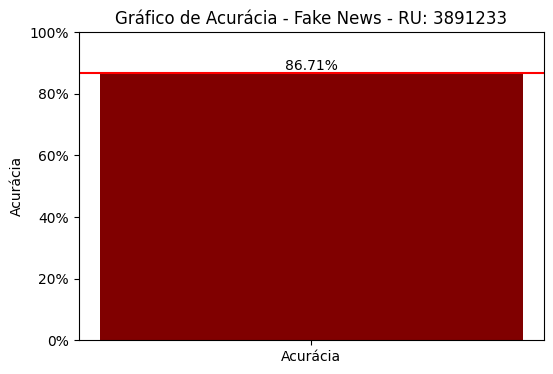

In [32]:
verifica_accuracy(y_test, predicted, ru3891233)

##### 4.7 - NUVEM DE PALAVRAS DOS TEXTOS VERDADEIROS - REAL

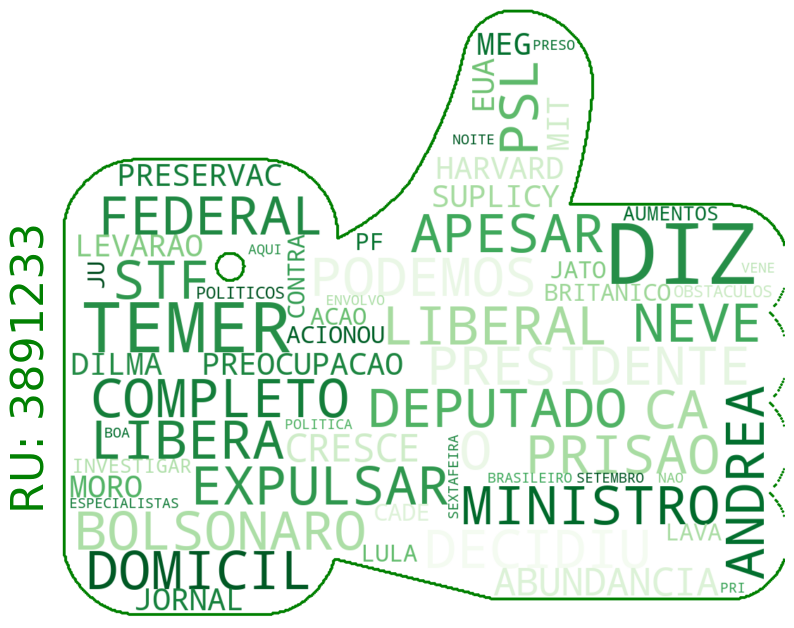

In [30]:
show_wordcloud(
    df[df["tag"] == "REAL"]["news_text_normalized"], title="Real Texto", 
    mask_path=mask_path_positivo, colormap="Greens", contour_color="green", 
    ru3891233="RU: 3891233", altura=700)

##### 4.8 - NUVEM DE PALAVRAS DOS TEXTOS FALSOS - FAKE

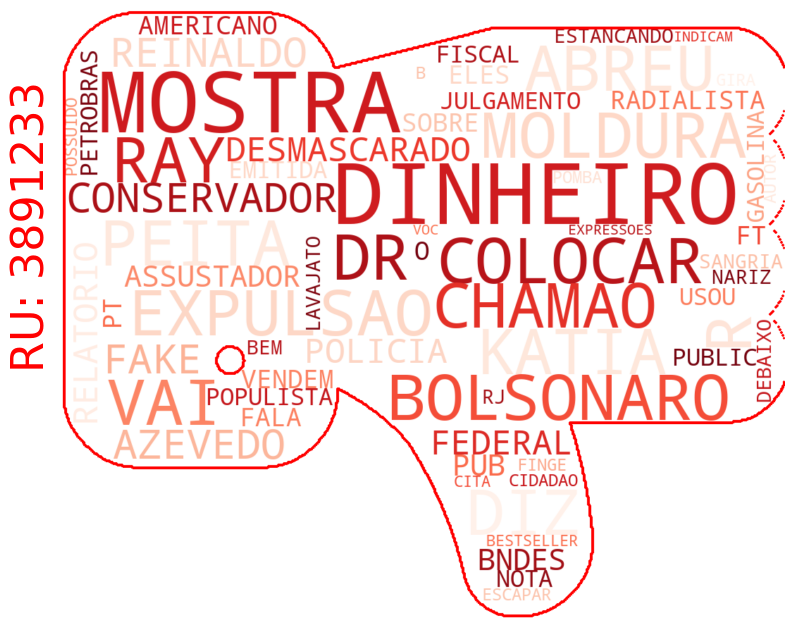

In [31]:
show_wordcloud(
    df[df["tag"] == "FAKE"]["news_text_normalized"], title="Fake Texto",
    mask_path=mask_path_negativo, colormap="Reds",  contour_color="red",
    ru3891233="RU: 3891233", altura=500)